<a href="https://colab.research.google.com/github/Neo-glitch/computer-vision-masterclass/blob/main/Human_Gestures_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* involves a neural network(MPII Model) that predicts one or more of the 16 points of the body

### **Detecting Body Points** ###

In [1]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np

* Loading Image

In [2]:
# load image
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
image = cv2.imread("/content/drive/MyDrive/Computer Vision Masterclass Files/Images/megan.jpg")

image.shape

(337, 600, 3)

In [4]:
# change image shape to shape expected by the NN

# does Mean subtraction to pixel of image and scaleFactor helps us in normalizing data
# ret shape is in (1, {n_color_channels}, {image_height}, {image_width})
image_blob = cv2.dnn.blobFromImage(image = image, scalefactor = 1 / 255.,
                                   size = (image.shape[1], image.shape[0]))

image_blob.shape

(1, 3, 337, 600)

* Loading the Pre-trained neural network using Caffe DL framework

In [5]:
# first param is model structure and other is model wieght
network = cv2.dnn.readNetFromCaffe("/content/drive/MyDrive/Computer Vision Masterclass Files/Weights/pose_deploy_linevec_faster_4_stages.prototxt", 
                                   "/content/drive/MyDrive/Computer Vision Masterclass Files/Weights/pose_iter_160000.caffemodel")

In [6]:
network.getLayerNames()

('conv1_1',
 'relu1_1',
 'conv1_2',
 'relu1_2',
 'pool1_stage1',
 'conv2_1',
 'relu2_1',
 'conv2_2',
 'relu2_2',
 'pool2_stage1',
 'conv3_1',
 'relu3_1',
 'conv3_2',
 'relu3_2',
 'conv3_3',
 'relu3_3',
 'conv3_4',
 'relu3_4',
 'pool3_stage1',
 'conv4_1',
 'relu4_1',
 'conv4_2',
 'relu4_2',
 'conv4_3_CPM',
 'relu4_3_CPM',
 'conv4_4_CPM',
 'relu4_4_CPM',
 'conv5_1_CPM_L1',
 'relu5_1_CPM_L1',
 'conv5_1_CPM_L2',
 'relu5_1_CPM_L2',
 'conv5_2_CPM_L1',
 'relu5_2_CPM_L1',
 'conv5_2_CPM_L2',
 'relu5_2_CPM_L2',
 'conv5_3_CPM_L1',
 'relu5_3_CPM_L1',
 'conv5_3_CPM_L2',
 'relu5_3_CPM_L2',
 'conv5_4_CPM_L1',
 'relu5_4_CPM_L1',
 'conv5_4_CPM_L2',
 'relu5_4_CPM_L2',
 'conv5_5_CPM_L1',
 'conv5_5_CPM_L2',
 'concat_stage2',
 'Mconv1_stage2_L1',
 'Mrelu1_stage2_L1',
 'Mconv1_stage2_L2',
 'Mrelu1_stage2_L2',
 'Mconv2_stage2_L1',
 'Mrelu2_stage2_L1',
 'Mconv2_stage2_L2',
 'Mrelu2_stage2_L2',
 'Mconv3_stage2_L1',
 'Mrelu3_stage2_L1',
 'Mconv3_stage2_L2',
 'Mrelu3_stage2_L2',
 'Mconv4_stage2_L1',
 'Mrelu4_sta

In [7]:
len(network.getLayerNames())

127

* Predicting body points

In [9]:
# tells model that this will be the input shape to send to it
network.setInput(image_blob)

output = network.forward()  # forward pass of image to get output

In [10]:
# second pos is info about points detected and last two demensions show y, x  cord where point is found in the image
output.shape  

(1, 44, 43, 75)

In [44]:
# viz results
position_width = output.shape[3]
position_height = output.shape[2]

num_points = 15  # total point are 16 but we aren't considering background so points = 15
points = []   # to store total num of points
threshold = 0.5

for i in range(num_points):
  # access only image which is just 1 here in output and get detected 43 points probability for each point in focus e.g 0 for start # head
  # and get the max value of the prob as the prediction
  confidence_map = output[0, i, :, :]
  # print(len(confidence_map))

  _, confidence, _, point = cv2.minMaxLoc(confidence_map)
  # print(confidence)
  # print(point)  # in x, y

  # to get actual point of predicted point in image
  x = int((image.shape[1] * point[0]) / position_width)
  y = int((image.shape[0] * point[1]) / position_height)

  if confidence > threshold:
    cv2.circle(image, (x, y), 5, (0, 255, 0), thickness = -1)
    cv2.putText(image, f"{i}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255))
    points.append((x, y))
  else:
    points.append(None)

  print(x, y)

224 23
248 62
232 94
208 125
176 148
280 62
320 39
360 15
288 180
320 250
320 321
312 164
336 250
296 305
280 125


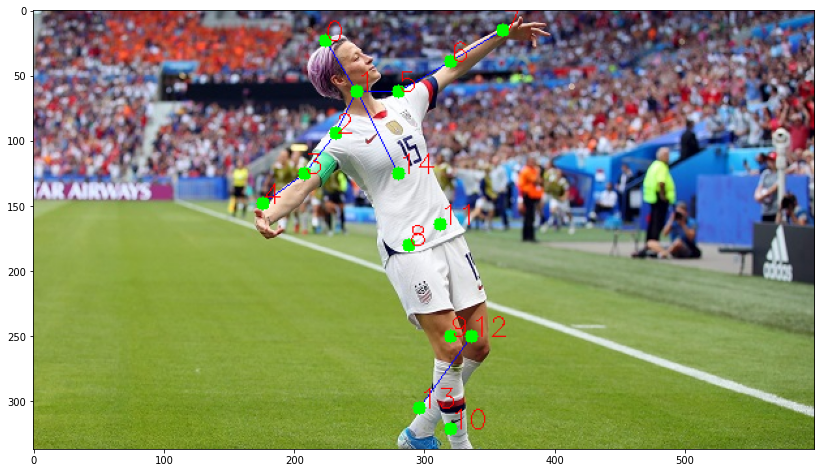

In [45]:
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

* Draw Line connecting all points detected to form a skeleton of some sort

In [46]:
point_connections = [[0, 1], [1, 2], [2, 3], [3, 4], [1, 5], [5, 6], [6, 7], [1, 14],
                     [14, 8], [8, 9], [9, 10], [14,11], [11, 12], [12, 13]]

point_connections

[[0, 1],
 [1, 2],
 [2, 3],
 [3, 4],
 [1, 5],
 [5, 6],
 [6, 7],
 [1, 14],
 [14, 8],
 [8, 9],
 [9, 10],
 [14, 11],
 [11, 12],
 [12, 13]]

In [47]:
for connection in point_connections:
  partA, partB = connection[0], connection[1]

  if points[partA] and points[partB]: # check if part A and part B exists in points list and aren't none
    cv2.line(image, points[partA], points[partB], (255, 0, 0))


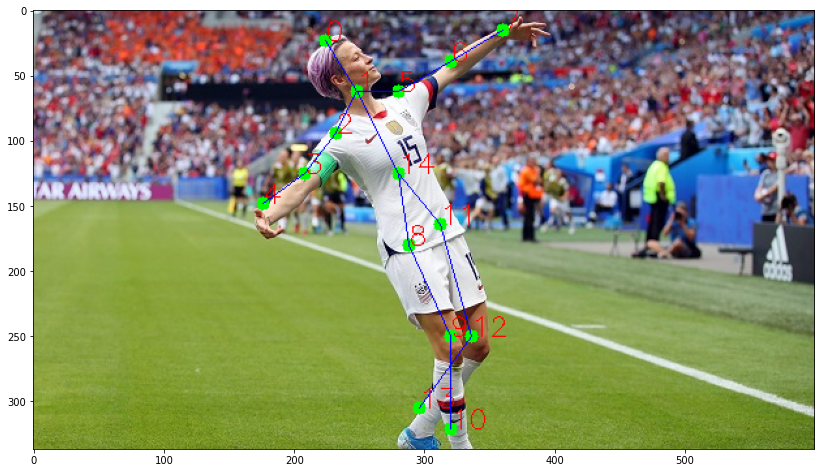

In [48]:
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

### **Detecting movements(arms above head movement)**

* Arms above head in images

In [ ]:
image2 = cv2.imread("/content/drive/MyDrive/Computer Vision Masterclass Files/Images/player.jpg")
cv2_imshow(image2)